# <span style="color:blue">Pre-analysis to find the optimal number of topics and hyperparameters values (2019_May)</span>

In [1]:
yyyy_MMM = '2019_May'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if debug is True, messages during the process are generated
debug = False
# for debugging purposes sample may be used to work with a smaller amount of data (when 0 it is not applied)
sample = 0
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = True

if test:
    # path where the doc files are stored
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where the model files are stored
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter'
    # LDA chunksize
    chunksize = 250
else:
    # path where the doc files are stored
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where the model files are stored
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model_hyperparameter'
    # LDA chunksize
    chunksize = 5000

file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc\2019_May\2019_May_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter\2019_May\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc)
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    ['cristian', 'knops', 'artist', 'draw', 'artwo...
1    ['fully', 'avert', 'controversy', 'finally', '...
2    ['sean', 'close', 'weekend', 'course', 'year',...
3    ['hailey', 'bieber', 'kendall', 'jenner', 'lea...
4                        ['feel', 'wedding', 'lovely']
5    ['black', 'plaid', 'chanel', 'chanel', 'chanel...
6    ['steph', 'kaaaa', 'japan', 'bikini', 'tokyo',...
7    ['laugh', 'watch', 'scene', 'video', 'song', '...
8    ['beaute', 'beatrice', 'blog', 'good', 'morning']
9                                    ['dude', 'sense']
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1477    ['shanti', 'knot', 'yrrah', 'beautiful', 'cere...
304     ['service', 'yummy', 'food', 'pic', 'food', 'g...
442     ['yean', 'hannah', 'drew', 'event', 'shade', '...
3561    ['lady', 'esthero', 'juma', 'married', 'mode',...
757     ['feliz', 'ivers', 'bubble', 'shamar', 'mauric...
2603                          ['nlechoppacrowdnlechoppa']
3547    ['sandra', 'sandra', 'calloway', 'event', 'upw...
3807    ['voyage', 'fest', 'maroc', 'morocco', 'travel...
3060    ['pomme', 'press', 'tatin', 'tartare', 'feuill...
1094    ['day', 'regret', 'enjoy', 'baby', 'weekend', ...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text  
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Function to compute bigrams & trigrams  
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [8]:
# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Function for categorizing and tagging words

In [9]:
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Analysis to get the optimal number of topics  
https://towardsdatascience.com/discover-what-singaporeans-generally-talk-on-sms-d4b592a682fd

In [10]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
model_list = []
coherence_score = []
model_topics = []

for num_topics in range(8, 25, 2):
    
    time_start = time.time()

    lda_x = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=10)
    coherence_lda_model = CoherenceModel(model=lda_x, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    model_topics.append(num_topics)
    model_list.append(lda_x)
    
    print("# Topics: " + str(num_topics) + " Score: " + str(coherence))
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topics: 8 Score: 0.5458591777920832
time elapsed - 00:00:27.15
# Topics: 10 Score: 0.5051394233989208
time elapsed - 00:00:26.77
# Topics: 12 Score: 0.49614795027038566
time elapsed - 00:00:27.44
# Topics: 14 Score: 0.48607323544451075
time elapsed - 00:00:27.78
# Topics: 16 Score: 0.5351975326129151
time elapsed - 00:00:28.74
# Topics: 18 Score: 0.5447190009711277
time elapsed - 00:00:29.75
# Topics: 20 Score: 0.5329680901240664
time elapsed - 00:00:29.14
# Topics: 22 Score: 0.5197128430074236
time elapsed - 00:00:29.72
# Topics: 24 Score: 0.5373096418848484
time elapsed - 00:00:31.98


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


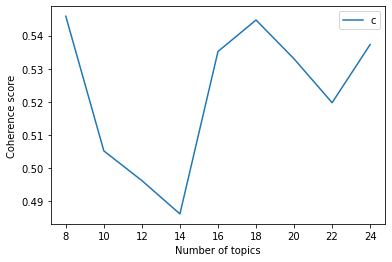

In [12]:
limit=25; start=8; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_score)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Hyperparameter tuning  

https://medium.com/analytics-vidhya/analyzing-amazon-tv-reviews-with-latent-dirichlet-allocation-97d19c3bb878  
https://github.com/Georgebob256/Machine-learning-with-Python/blob/master/Amazon%20TV%20reviews..ipynb

In [13]:
# LDA model and its corresponding Coherence Score
def compute_coherence_values(bow_corpus, id2word, n, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus
                                           ,id2word=id2word
                                           ,num_topics=n
                                           ,random_state=random_state
                                           ,chunksize=chunksize
                                           ,passes=10
                                           ,alpha=a
                                           ,eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 8
max_topics = 25
step_size = 2
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = [0.01, 0.31, 0.61, 0.91, 'symmetric', 'asymmetric']

# Beta parameter
beta = [0.01, 0.31, 0.61, 0.91, 'symmetric']

model_results = {'Topics': []
                 ,'Alpha': []
                 ,'Beta': []
                 ,'Coherence': []
                }

# iterate through number of topics
iter = 0
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            iter += 1
            # get the coherence score for the given parameters
            cv = compute_coherence_values(bow_corpus=corpus
                                          ,id2word=id2word
                                          ,n=k
                                          ,a=a
                                          ,b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print('Iteration num - ', iter, ' Topics - ', k, ' Alpha - ', a, ' Beta - ', b, ' Coherence - ', cv)

pd.DataFrame(model_results).to_csv(file_model + '_lda_tuning_results.csv', index=False)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration num -  1  Topics -  8  Alpha -  0.01  Beta -  0.01  Coherence -  0.46800008245213465
Iteration num -  2  Topics -  8  Alpha -  0.01  Beta -  0.31  Coherence -  0.41209095980488153
Iteration num -  3  Topics -  8  Alpha -  0.01  Beta -  0.61  Coherence -  0.46174699399322705
Iteration num -  4  Topics -  8  Alpha -  0.01  Beta -  0.91  Coherence -  0.4779645800411715
Iteration num -  5  Topics -  8  Alpha -  0.01  Beta -  symmetric  Coherence -  0.49303155014985456
Iteration num -  6  Topics -  8  Alpha -  0.31  Beta -  0.01  Coherence -  0.5337336448877175
Iteration num -  7  Topics -  8  Alpha -  0.31  Beta -  0.31  Coherence -  0.4258329155297576
Iteration num -  8  Topics -  8  Alpha -  0.31  Beta -  0.61  Coherence -  0.5402738143793138
Iteration num -  9  Topics -  8  Alpha -  0.31  Beta -  0.91  Coherence -  0.38880628896332636
Iteration num -  10  Topics -  8  Alpha -  0.31  Beta -  symmetric  Coherence -  0.5481133857481301
Iteration num -  11  Topics -  8  Alpha -  0

Iteration num -  85  Topics -  12  Alpha -  symmetric  Beta -  symmetric  Coherence -  0.4975816748654575
Iteration num -  86  Topics -  12  Alpha -  asymmetric  Beta -  0.01  Coherence -  0.5408791922590392
Iteration num -  87  Topics -  12  Alpha -  asymmetric  Beta -  0.31  Coherence -  0.5346606916407629
Iteration num -  88  Topics -  12  Alpha -  asymmetric  Beta -  0.61  Coherence -  0.5200294086587206
Iteration num -  89  Topics -  12  Alpha -  asymmetric  Beta -  0.91  Coherence -  0.4550853353367559
Iteration num -  90  Topics -  12  Alpha -  asymmetric  Beta -  symmetric  Coherence -  0.5243810981878909
Iteration num -  91  Topics -  14  Alpha -  0.01  Beta -  0.01  Coherence -  0.4731952347697407
Iteration num -  92  Topics -  14  Alpha -  0.01  Beta -  0.31  Coherence -  0.46249847847959863
Iteration num -  93  Topics -  14  Alpha -  0.01  Beta -  0.61  Coherence -  0.4355010658267901
Iteration num -  94  Topics -  14  Alpha -  0.01  Beta -  0.91  Coherence -  0.48395868499

Iteration num -  168  Topics -  18  Alpha -  0.91  Beta -  0.61  Coherence -  0.5424817491086629
Iteration num -  169  Topics -  18  Alpha -  0.91  Beta -  0.91  Coherence -  0.5658789980310426
Iteration num -  170  Topics -  18  Alpha -  0.91  Beta -  symmetric  Coherence -  0.5821219741676507
Iteration num -  171  Topics -  18  Alpha -  symmetric  Beta -  0.01  Coherence -  0.5658087853626722
Iteration num -  172  Topics -  18  Alpha -  symmetric  Beta -  0.31  Coherence -  0.5466690897767155
Iteration num -  173  Topics -  18  Alpha -  symmetric  Beta -  0.61  Coherence -  0.5388416471568025
Iteration num -  174  Topics -  18  Alpha -  symmetric  Beta -  0.91  Coherence -  0.5035551579784788
Iteration num -  175  Topics -  18  Alpha -  symmetric  Beta -  symmetric  Coherence -  0.5362349011090081
Iteration num -  176  Topics -  18  Alpha -  asymmetric  Beta -  0.01  Coherence -  0.5434027226801442
Iteration num -  177  Topics -  18  Alpha -  asymmetric  Beta -  0.31  Coherence -  0.

Iteration num -  250  Topics -  24  Alpha -  0.31  Beta -  symmetric  Coherence -  0.5238443601169086
Iteration num -  251  Topics -  24  Alpha -  0.61  Beta -  0.01  Coherence -  0.5376170889052788
Iteration num -  252  Topics -  24  Alpha -  0.61  Beta -  0.31  Coherence -  0.4672027397095091
Iteration num -  253  Topics -  24  Alpha -  0.61  Beta -  0.61  Coherence -  0.438295175844233
Iteration num -  254  Topics -  24  Alpha -  0.61  Beta -  0.91  Coherence -  0.4620873418502766
Iteration num -  255  Topics -  24  Alpha -  0.61  Beta -  symmetric  Coherence -  0.5249412271796837
Iteration num -  256  Topics -  24  Alpha -  0.91  Beta -  0.01  Coherence -  0.5584134866266733
Iteration num -  257  Topics -  24  Alpha -  0.91  Beta -  0.31  Coherence -  0.5125115760250137
Iteration num -  258  Topics -  24  Alpha -  0.91  Beta -  0.61  Coherence -  0.47418900205253856
Iteration num -  259  Topics -  24  Alpha -  0.91  Beta -  0.91  Coherence -  0.44607924010382183
Iteration num -  26

In [14]:
pd.DataFrame(model_results).sort_values(by=['Coherence'], ascending=False)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topics,Alpha,Beta,Coherence
128,16,0.31,0.91,0.614211
139,16,0.91,symmetric,0.607177
158,18,0.31,0.91,0.597790
164,18,0.61,symmetric,0.594144
137,16,0.91,0.61,0.592289
...,...,...,...,...
97,14,0.31,0.61,0.432582
6,8,0.31,0.31,0.425833
112,14,symmetric,0.61,0.425701
1,8,0.01,0.31,0.412091
